In [1]:
import scanpy as sc
data_dir = '../../dataset/GEX_human_neocortex_filtered.h5ad'
adata = sc.read_h5ad(data_dir)
print(adata.X)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 560546360 stored elements and shape (232328, 18944)>
  Coords	Values
  (0, 9055)	1.0
  (0, 484)	1.0
  (0, 8769)	1.0
  (0, 15607)	1.0
  (0, 5958)	1.0
  (0, 6754)	2.0
  (0, 10091)	4.0
  (0, 720)	1.0
  (0, 211)	2.0
  (0, 5468)	1.0
  (0, 9205)	1.0
  (0, 13556)	2.0
  (0, 550)	2.0
  (0, 5036)	1.0
  (0, 14257)	1.0
  (0, 16799)	1.0
  (0, 4038)	4.0
  (0, 4799)	1.0
  (0, 13032)	1.0
  (0, 1974)	2.0
  (0, 14845)	1.0
  (0, 17775)	3.0
  (0, 9728)	1.0
  (0, 17921)	1.0
  (0, 12549)	1.0
  :	:
  (232327, 13612)	1.0
  (232327, 4926)	1.0
  (232327, 647)	2.0
  (232327, 10195)	2.0
  (232327, 9526)	1.0
  (232327, 12032)	1.0
  (232327, 8830)	2.0
  (232327, 6370)	15.0
  (232327, 99)	3.0
  (232327, 14319)	1.0
  (232327, 14924)	1.0
  (232327, 5053)	7.0
  (232327, 9166)	4.0
  (232327, 18338)	2.0
  (232327, 10926)	1.0
  (232327, 14013)	2.0
  (232327, 2278)	1.0
  (232327, 14281)	1.0
  (232327, 11653)	1.0
  (232327, 11494)	7.0
  (232327, 13872)	1.0
  (232

In [2]:
import scanpy as sc
import torch
from torch import nn
import lightning.pytorch as pl
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.estimator.cellnet import EstimatorAutoEncoder

# 设置你的 .ckpt 文件路径
ckpt_path = "../../sc_pretrained/Pretrained Models/GPMask.ckpt"

# 模型参数
units_encoder = [512, 512, 256, 256, 64]
units_decoder = [256, 256, 512, 512]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 如果没有实际数据路径，可以设置为None

# 加载预训练模型
estim.model = MLPAutoEncoder.load_from_checkpoint(
    ckpt_path,
    gene_dim=19331,  # 根据你的数据调整
    batch_size=128,  # 根据你的需要调整
    units_encoder=units_encoder, 
    units_decoder=units_decoder,
    masking_strategy="random",  # 假设模型使用了随机掩码
    masking_rate=0.5,  # 根据需要调整
)

# 使用 GPU 进行评估（如果可用）
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
estim.model

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [3]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

34

In [4]:
import pandas as pd
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
var_df

,feature_id,feature_name
0,ENSG00000186092,OR4F5
1,ENSG00000284733,OR4F29
2,ENSG00000284662,OR4F16
3,ENSG00000187634,SAMD11
4,ENSG00000188976,NOC2L
...,...,...
19326,ENSG00000288702,UGT1A3
19327,ENSG00000288705,UGT1A5
19328,ENSG00000182484,WASH6P
19329,ENSG00000288622,PDCD6-AHRR


In [5]:
all_genes = var_df['feature_name'].tolist()
all_genes

['OR4F5',
 'OR4F29',
 'OR4F16',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'HES4',
 'ISG15',
 'AGRN',
 'RNF223',
 'C1orf159',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'C1QTNF12',
 'UBE2J2',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'INTS11',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20',
 'ANKRD65',
 'TMEM88B',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'FNDC10',
 'MIB2',
 'MMP23B',
 'CDK11B',
 'SLC35E2B',
 'CDK11A',
 'NADK',
 'GNB1',
 'CALML6',
 'TMEM52',
 'CFAP74',
 'GABRD',
 'PRKCZ',
 'FAAP20',
 'SKI',
 'MORN1',
 'RER1',
 'PEX10',
 'PLCH2',
 'PANK4',
 'HES5',
 'TNFRSF14',
 'PRXL2B',
 'MMEL1',
 'TTC34',
 'ACTRT2',
 'PRDM16',
 'ARHGEF16',
 'MEGF6',
 'TPRG1L',
 'WRAP73',
 'TP73',
 'CCDC27',
 'SMIM1',
 'LRRC47',
 'CEP104',
 'DFFB',
 'C1orf174',
 'AJAP1',
 'NPHP4',
 'KCNAB2',
 'CHD5',
 'RPL22',
 'RNF207',
 'ICMT',
 'HES3',
 'GPR153',
 'ACOT7',
 'HES2',
 'ESPN',
 'TNFRSF25',
 'PLEKHG5',
 'NOL9',
 'TAS1R1',
 'ZBTB48',
 'KLH

In [6]:
adata.var['gene_name']=adata.var.index
adata.var['gene_name']

ATXN7L1    ATXN7L1
ZNF593      ZNF593
SLC44A1    SLC44A1
COX18        COX18
FSIP2        FSIP2
            ...   
TOX3          TOX3
BUB1          BUB1
RHNO1        RHNO1
CSTF3        CSTF3
FSD1L        FSD1L
Name: gene_name, Length: 18944, dtype: object

In [7]:
import numpy as np
# 初始化一个新的数据矩阵，形状为 (adata.X.shape[0], len(all_genes))，填充为零
new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)

In [8]:
existing_genes = adata.var['gene_name']
existing_genes

ATXN7L1    ATXN7L1
ZNF593      ZNF593
SLC44A1    SLC44A1
COX18        COX18
FSIP2        FSIP2
            ...   
TOX3          TOX3
BUB1          BUB1
RHNO1        RHNO1
CSTF3        CSTF3
FSD1L        FSD1L
Name: gene_name, Length: 18944, dtype: object

In [9]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes


匹配的基因数量: 18944
匹配的基因列表: {'ido1', 'rabac1', 'nrxn1', 'vstm2a', 'tifab', 'kcnn2', 'tns2', 'med16', 'six3', 'or5h2', 'fate1', 'rpn1', 'ermard', 'ccnt2', 'tti2', 'prm2', 'cmc2', 'rec8', 'plcb4', 'rps13', 'dennd2d', 'ptpn14', 'apol6', 'gldc', 'arhgap45', 'sugt1', 'actrt3', 'lyg2', 'hbp1', 'gphb5', 'nkiras2', 'tmem44', 'or11h1', 'zcchc24', 'gage12d', 'pstpip2', 'cdc14c', 'nanos1', 'or51d1', 'prkcg', 'gdi2', 'znf571', 'elavl1', 'fbxl4', 'bzw2', 'xage1a', 'slc35b1', 'pde6b', 'zfp30', 'angptl8', 'p2rx2', 'rpel1', 'eddm13', 'znf556', 'znf154', 'sage1', 'tor3a', 'slc66a1', 'arhgap10', 'tex46', 'sult2b1', 'qser1', 'mdh1b', 'tent5d', 'znf732', 'srp14', 'hgfac', 'slc5a11', 'wls', 'slc8b1', 'ampd3', 'acp5', 'myoc', 'adal', 'hif1a', 'cmas', 'znf385c', 'alg10', 'adam18', 'acot4', 'tlcd1', 'cdy1', 'flrt1', 'zfp92', 'rbp1', 'spata31a1', 'clec4f', 'perm1', 'slc22a3', 'fignl2', 'exoc6b', 'krt8', 'tbrg4', 'slc5a9', 'eef1d', 'clptm1', 'sox9', 'znf385d', 'fezf2', 'cxcl1', 'fgfbp1', 'hgs', 'lmbrd2', 'apip', 'w

set()

In [10]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
gene_to_index

{'or4f5': 0,
 'or4f29': 1,
 'or4f16': 2,
 'samd11': 3,
 'noc2l': 4,
 'klhl17': 5,
 'plekhn1': 6,
 'perm1': 7,
 'hes4': 8,
 'isg15': 9,
 'agrn': 10,
 'rnf223': 11,
 'c1orf159': 12,
 'ttll10': 13,
 'tnfrsf18': 14,
 'tnfrsf4': 15,
 'sdf4': 16,
 'b3galt6': 17,
 'c1qtnf12': 18,
 'ube2j2': 19,
 'scnn1d': 20,
 'acap3': 21,
 'pusl1': 22,
 'ints11': 23,
 'cptp': 24,
 'tas1r3': 25,
 'dvl1': 26,
 'mxra8': 27,
 'aurkaip1': 28,
 'ccnl2': 29,
 'mrpl20': 30,
 'ankrd65': 31,
 'tmem88b': 32,
 'vwa1': 33,
 'atad3c': 34,
 'atad3b': 35,
 'atad3a': 36,
 'tmem240': 37,
 'ssu72': 38,
 'fndc10': 39,
 'mib2': 40,
 'mmp23b': 41,
 'cdk11b': 42,
 'slc35e2b': 43,
 'cdk11a': 44,
 'nadk': 45,
 'gnb1': 46,
 'calml6': 47,
 'tmem52': 48,
 'cfap74': 49,
 'gabrd': 50,
 'prkcz': 51,
 'faap20': 52,
 'ski': 53,
 'morn1': 54,
 'rer1': 55,
 'pex10': 56,
 'plch2': 57,
 'pank4': 58,
 'hes5': 59,
 'tnfrsf14': 60,
 'prxl2b': 61,
 'mmel1': 62,
 'ttc34': 63,
 'actrt2': 64,
 'prdm16': 65,
 'arhgef16': 66,
 'megf6': 67,
 'tprg1l': 68

In [11]:
only_in_all_genes = all_genes_set - adata_genes_set

only_in_adata_genes = adata_genes_set - all_genes_set

# 输出结果
print(f"仅在 all_genes 中存在的基因数量: {len(only_in_all_genes)}")
print(f"仅在 all_genes 中存在的基因: {only_in_all_genes}")

print(f"仅在 adata_genes 中存在的基因数量: {len(only_in_adata_genes)}")
print(f"仅在 adata_genes 中存在的基因: {only_in_adata_genes}")


仅在 all_genes 中存在的基因数量: 387
仅在 all_genes 中存在的基因: {'dync2i2', 'h2bc1', 'zfp91-cntf', 'atp5mf-ptcd1', 'iho1', 'coro7-pam16', 'h3-3a', 'znf625-znf20', 'peds1-ube2v1', 'marchf11', 'ankrd20a4p', 'bloc1s5-txndc5', 'rtel1-tnfrsf6b', 'senp3-eif4a1', 'poc1b-galnt4', 'mroh7-ttc4', 'cfap20dc', 'dnai4', 'cenatac', 'gfus', 'ino80b-wbp1', 'rpl36a-hnrnph2', 'spring1', 'cilk1', 'gars1', 'tasl', 'stx16-npepl1', 'brme1', 'h1-0', 'h2ac8', 'igll5', 'h3c2', 'h2az1', 'apoc4-apoc2', 'pttg1ip2', 'h2ax', 'ankhd1-eif4ebp3', 'h2ac16', 'h1-1', 'zhx1-c8orf76', 'mars1', 'percc1', 'ten1-cdk3', 'h2al1rp', 'pwwp4', 'pabir3', 'ankrd20a3p', 'ins-igf2', 'rusf1', 'klrc4-klrk1', 'fxyd6-fxyd2', 'eef1e1-bloc1s5', 'hrob', 'fpgt-tnni3k', 'bub1b-pak6', 'sys1-dbndd2', 'h4c12', 'ankrd20a2p', 'palm2akap2', 'h2ab3', 'eprs1', 'gimap1-gimap5', 'isy1-rab43', 'ccdc169-sohlh2', 'h1-4', 'dnaaf6', 'atf7-npff', 'p3r3urf-pik3r3', 'h2ac19', 'specc1l-adora2a', 'tmem256-plscr3', 'tbcel-tecta', 'h2bc18', 'h2bw1', 'fam246b', 'nfilz', 'psme3ip1', 

In [12]:
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

In [13]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42
X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

cuda


MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [14]:
# 6. 微调模型，仅微调 encoder 的最后两层，其他层参数冻结
for param in estim.model.encoder.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻最后两层
for param in list(estim.model.encoder.parameters())[-5:]:
    param.requires_grad = True

In [15]:
from torch.optim import AdamW
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [16]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.encoder(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.encoder(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [17]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")


Epoch 1, Train Loss: 1.0268445040980818, Validation Loss: 0.7633393072819972
Validation loss improved to 0.7633393072819972, resetting patience.


Epoch 2, Train Loss: 0.8452179275752052, Validation Loss: 0.7284280300795377
Validation loss improved to 0.7284280300795377, resetting patience.


Epoch 3, Train Loss: 0.8230363963674505, Validation Loss: 0.7146457012319739
Validation loss improved to 0.7146457012319739, resetting patience.


Epoch 4, Train Loss: 0.8122302648544687, Validation Loss: 0.7148857388522599
No improvement in validation loss. Patience counter: 1/20


Epoch 5, Train Loss: 0.8056669856599707, Validation Loss: 0.6939848176725618
Validation loss improved to 0.6939848176725618, resetting patience.


Epoch 6, Train Loss: 0.79958580977142, Validation Loss: 0.6860281541233971
Validation loss improved to 0.6860281541233971, resetting patience.


Epoch 7, Train Loss: 0.7973492085511622, Validation Loss: 0.6816080309750833
Validation loss improved to 0.6816080309750833, resetting patience.


Epoch 8, Train Loss: 0.7869807748368741, Validation Loss: 0.6791662382773864
Validation loss improved to 0.6791662382773864, resetting patience.


Epoch 9, Train Loss: 0.7861155790901859, Validation Loss: 0.6877995146499886
No improvement in validation loss. Patience counter: 1/20


Epoch 10, Train Loss: 0.782735925153144, Validation Loss: 0.6764804731795203
Validation loss improved to 0.6764804731795203, resetting patience.


Epoch 11, Train Loss: 0.7823502484688507, Validation Loss: 0.6806900044937274
No improvement in validation loss. Patience counter: 1/20


Epoch 12, Train Loss: 0.7786244036736777, Validation Loss: 0.6735399926538432
Validation loss improved to 0.6735399926538432, resetting patience.


Epoch 13, Train Loss: 0.7771530852460373, Validation Loss: 0.6740385122569926
No improvement in validation loss. Patience counter: 1/20


Epoch 14, Train Loss: 0.7735207448739128, Validation Loss: 0.6828472247490516
No improvement in validation loss. Patience counter: 2/20


Epoch 15, Train Loss: 0.7746784815067949, Validation Loss: 0.6796339344192337
No improvement in validation loss. Patience counter: 3/20


Epoch 16, Train Loss: 0.7702938179440803, Validation Loss: 0.6674937826373202
Validation loss improved to 0.6674937826373202, resetting patience.


Epoch 17, Train Loss: 0.7698079333541714, Validation Loss: 0.6670898558237613
Validation loss improved to 0.6670898558237613, resetting patience.


Epoch 18, Train Loss: 0.7698334796423053, Validation Loss: 0.6845258206893237
No improvement in validation loss. Patience counter: 1/20


Epoch 19, Train Loss: 0.7681331292885106, Validation Loss: 0.6700660221742623
No improvement in validation loss. Patience counter: 2/20


Epoch 20, Train Loss: 0.7675258333433528, Validation Loss: 0.6653325888481769
Validation loss improved to 0.6653325888481769, resetting patience.


Epoch 21, Train Loss: 0.7669499456929373, Validation Loss: 0.6693894729946123
No improvement in validation loss. Patience counter: 1/20


Epoch 22, Train Loss: 0.7663746091861785, Validation Loss: 0.6704675282314146
No improvement in validation loss. Patience counter: 2/20


Epoch 23, Train Loss: 0.7638605371598275, Validation Loss: 0.6747108565800356
No improvement in validation loss. Patience counter: 3/20


Epoch 24, Train Loss: 0.7633701805333093, Validation Loss: 0.6712685911865025
No improvement in validation loss. Patience counter: 4/20


Epoch 25, Train Loss: 0.7633450630844155, Validation Loss: 0.6650388300855518
Validation loss improved to 0.6650388300855518, resetting patience.


Epoch 26, Train Loss: 0.7641719488249717, Validation Loss: 0.6665527035683503
No improvement in validation loss. Patience counter: 1/20


Epoch 27, Train Loss: 0.7605135712118997, Validation Loss: 0.6713718352737007
No improvement in validation loss. Patience counter: 2/20


Epoch 28, Train Loss: 0.76087843347121, Validation Loss: 0.6691406017694718
No improvement in validation loss. Patience counter: 3/20


Epoch 29, Train Loss: 0.7599192590201398, Validation Loss: 0.6644156714935443
Validation loss improved to 0.6644156714935443, resetting patience.


Epoch 30, Train Loss: 0.7593902946221932, Validation Loss: 0.6729256022762466
No improvement in validation loss. Patience counter: 1/20


Epoch 31, Train Loss: 0.7600810218288803, Validation Loss: 0.6674615940549872
No improvement in validation loss. Patience counter: 2/20


Epoch 32, Train Loss: 0.7574598602100585, Validation Loss: 0.6645773346825834
No improvement in validation loss. Patience counter: 3/20


Epoch 33, Train Loss: 0.7591946444156881, Validation Loss: 0.670307844440579
No improvement in validation loss. Patience counter: 4/20


Epoch 34, Train Loss: 0.7588585009263502, Validation Loss: 0.6658995622025304
No improvement in validation loss. Patience counter: 5/20


Epoch 35, Train Loss: 0.7571473447334851, Validation Loss: 0.6720038105498304
No improvement in validation loss. Patience counter: 6/20


Epoch 36, Train Loss: 0.7577097210285703, Validation Loss: 0.6671678435889793
No improvement in validation loss. Patience counter: 7/20


Epoch 37, Train Loss: 0.755792400787235, Validation Loss: 0.6664580863255721
No improvement in validation loss. Patience counter: 8/20


Epoch 38, Train Loss: 0.757234619251862, Validation Loss: 0.6752968755833831
No improvement in validation loss. Patience counter: 9/20


Epoch 39, Train Loss: 0.7566691995792554, Validation Loss: 0.6664098240298666
No improvement in validation loss. Patience counter: 10/20


Epoch 40, Train Loss: 0.756274404251885, Validation Loss: 0.6680936818812793
No improvement in validation loss. Patience counter: 11/20


Epoch 41, Train Loss: 0.7551683021473378, Validation Loss: 0.6591983787961059
Validation loss improved to 0.6591983787961059, resetting patience.


Epoch 42, Train Loss: 0.7545556824428654, Validation Loss: 0.6703008603263687
No improvement in validation loss. Patience counter: 1/20


Epoch 43, Train Loss: 0.754317627963262, Validation Loss: 0.6582078834374746
Validation loss improved to 0.6582078834374746, resetting patience.


Epoch 44, Train Loss: 0.7549714020722312, Validation Loss: 0.6657263698813679
No improvement in validation loss. Patience counter: 1/20


Epoch 45, Train Loss: 0.7543685364029147, Validation Loss: 0.6642302566177243
No improvement in validation loss. Patience counter: 2/20


Epoch 46, Train Loss: 0.7551722646603708, Validation Loss: 0.66081899699274
No improvement in validation loss. Patience counter: 3/20


Epoch 47, Train Loss: 0.7532857995535988, Validation Loss: 0.6788444916407267
No improvement in validation loss. Patience counter: 4/20


Epoch 48, Train Loss: 0.7557035797135648, Validation Loss: 0.6578250849421644
Validation loss improved to 0.6578250849421644, resetting patience.


Epoch 49, Train Loss: 0.7520015864368502, Validation Loss: 0.6763721952289888
No improvement in validation loss. Patience counter: 1/20


Epoch 50, Train Loss: 0.7513111505003823, Validation Loss: 0.6671401615981217
No improvement in validation loss. Patience counter: 2/20


Epoch 51, Train Loss: 0.7520329652340931, Validation Loss: 0.6737174255289001
No improvement in validation loss. Patience counter: 3/20


Epoch 52, Train Loss: 0.7521151026621473, Validation Loss: 0.6665116831278189
No improvement in validation loss. Patience counter: 4/20


Epoch 53, Train Loss: 0.7535296410533221, Validation Loss: 0.6733735344567142
No improvement in validation loss. Patience counter: 5/20


Epoch 54, Train Loss: 0.7534623532713538, Validation Loss: 0.6674228834581899
No improvement in validation loss. Patience counter: 6/20


Epoch 55, Train Loss: 0.7536627853554502, Validation Loss: 0.664814096121561
No improvement in validation loss. Patience counter: 7/20


Epoch 56, Train Loss: 0.7521090359081911, Validation Loss: 0.6546104988117358
Validation loss improved to 0.6546104988117358, resetting patience.


Epoch 57, Train Loss: 0.7549128920941912, Validation Loss: 0.6667641427490737
No improvement in validation loss. Patience counter: 1/20


Epoch 58, Train Loss: 0.7516696354378686, Validation Loss: 0.6725639593906891
No improvement in validation loss. Patience counter: 2/20


Epoch 59, Train Loss: 0.7536353037452997, Validation Loss: 0.6580840651587252
No improvement in validation loss. Patience counter: 3/20


Epoch 60, Train Loss: 0.7526990616068326, Validation Loss: 0.6589599325980022
No improvement in validation loss. Patience counter: 4/20


Epoch 61, Train Loss: 0.7513846910956523, Validation Loss: 0.6589338679016729
No improvement in validation loss. Patience counter: 5/20


Epoch 62, Train Loss: 0.7540374147338627, Validation Loss: 0.6639170651034121
No improvement in validation loss. Patience counter: 6/20


Epoch 63, Train Loss: 0.7524654885195635, Validation Loss: 0.6609491817243807
No improvement in validation loss. Patience counter: 7/20


Epoch 64, Train Loss: 0.7535290913634372, Validation Loss: 0.6653363078068464
No improvement in validation loss. Patience counter: 8/20


Epoch 65, Train Loss: 0.7535194915922302, Validation Loss: 0.6646913550930582
No improvement in validation loss. Patience counter: 9/20


Epoch 66, Train Loss: 0.7517465814936358, Validation Loss: 0.6748020963354425
No improvement in validation loss. Patience counter: 10/20


Epoch 67, Train Loss: 0.753734753930972, Validation Loss: 0.6661901488190606
No improvement in validation loss. Patience counter: 11/20


Epoch 68, Train Loss: 0.7521873647823378, Validation Loss: 0.6686319919514568
No improvement in validation loss. Patience counter: 12/20


Epoch 69, Train Loss: 0.7548956606540035, Validation Loss: 0.6577006584995395
No improvement in validation loss. Patience counter: 13/20


Epoch 70, Train Loss: 0.7520810825490839, Validation Loss: 0.6656398710968731
No improvement in validation loss. Patience counter: 14/20


Epoch 71, Train Loss: 0.7527201188820539, Validation Loss: 0.6549400318236578
No improvement in validation loss. Patience counter: 15/20


Epoch 72, Train Loss: 0.7534868885784239, Validation Loss: 0.6540095027768131
Validation loss improved to 0.6540095027768131, resetting patience.


Epoch 73, Train Loss: 0.7523307230039247, Validation Loss: 0.6566788803090106
No improvement in validation loss. Patience counter: 1/20


Epoch 74, Train Loss: 0.7514401238139082, Validation Loss: 0.661900303193501
No improvement in validation loss. Patience counter: 2/20


Epoch 75, Train Loss: 0.7493624707125567, Validation Loss: 0.6554379490487304
No improvement in validation loss. Patience counter: 3/20


Epoch 76, Train Loss: 0.7503780887926028, Validation Loss: 0.6711782842547029
No improvement in validation loss. Patience counter: 4/20


Epoch 77, Train Loss: 0.7491742612854126, Validation Loss: 0.6691539599781945
No improvement in validation loss. Patience counter: 5/20


Epoch 78, Train Loss: 0.7523878496946265, Validation Loss: 0.6578762397006318
No improvement in validation loss. Patience counter: 6/20


Epoch 79, Train Loss: 0.7514030259955502, Validation Loss: 0.6764644310151264
No improvement in validation loss. Patience counter: 7/20


Epoch 80, Train Loss: 0.7506697770885179, Validation Loss: 0.6720211446940244
No improvement in validation loss. Patience counter: 8/20


Epoch 81, Train Loss: 0.7500604828636446, Validation Loss: 0.6524586907891563
Validation loss improved to 0.6524586907891563, resetting patience.


Epoch 82, Train Loss: 0.7513590559398537, Validation Loss: 0.6648585793081221
No improvement in validation loss. Patience counter: 1/20


Epoch 83, Train Loss: 0.7498152701522683, Validation Loss: 0.6622178277253231
No improvement in validation loss. Patience counter: 2/20


Epoch 84, Train Loss: 0.7487474819931057, Validation Loss: 0.6547588763874529
No improvement in validation loss. Patience counter: 3/20


Epoch 85, Train Loss: 0.7488702402445016, Validation Loss: 0.6746710043250422
No improvement in validation loss. Patience counter: 4/20


Epoch 86, Train Loss: 0.7511963161964477, Validation Loss: 0.6630048161242907
No improvement in validation loss. Patience counter: 5/20


Epoch 87, Train Loss: 0.7511248785524646, Validation Loss: 0.6588121698452876
No improvement in validation loss. Patience counter: 6/20


Epoch 88, Train Loss: 0.7518294230631071, Validation Loss: 0.6628535309117356
No improvement in validation loss. Patience counter: 7/20


Epoch 89, Train Loss: 0.7504609752648651, Validation Loss: 0.661363850583087
No improvement in validation loss. Patience counter: 8/20


Epoch 90, Train Loss: 0.7489782058986316, Validation Loss: 0.6521836593474224
Validation loss improved to 0.6521836593474224, resetting patience.


Epoch 91, Train Loss: 0.7480505675804324, Validation Loss: 0.6678616878313895
No improvement in validation loss. Patience counter: 1/20


Epoch 92, Train Loss: 0.7509854113277162, Validation Loss: 0.6587492126029927
No improvement in validation loss. Patience counter: 2/20


Epoch 93, Train Loss: 0.7505983704192539, Validation Loss: 0.6573286585973732
No improvement in validation loss. Patience counter: 3/20


Epoch 94, Train Loss: 0.7518492186988648, Validation Loss: 0.6579961876074473
No improvement in validation loss. Patience counter: 4/20


Epoch 95, Train Loss: 0.7506848093236552, Validation Loss: 0.6571416136546012
No improvement in validation loss. Patience counter: 5/20


Epoch 96, Train Loss: 0.7516046124213704, Validation Loss: 0.6772663988473214
No improvement in validation loss. Patience counter: 6/20


Epoch 97, Train Loss: 0.7496975772405214, Validation Loss: 0.6576345072779464
No improvement in validation loss. Patience counter: 7/20


Epoch 98, Train Loss: 0.7519169035246764, Validation Loss: 0.6664873181463598
No improvement in validation loss. Patience counter: 8/20


Epoch 99, Train Loss: 0.7502075727533675, Validation Loss: 0.6563359146371429
No improvement in validation loss. Patience counter: 9/20


Epoch 100, Train Loss: 0.7519978305938955, Validation Loss: 0.6571774049337967
No improvement in validation loss. Patience counter: 10/20


Epoch 101, Train Loss: 0.7495392204784765, Validation Loss: 0.656703599752524
No improvement in validation loss. Patience counter: 11/20


Epoch 102, Train Loss: 0.7497391527698886, Validation Loss: 0.6642204493611723
No improvement in validation loss. Patience counter: 12/20


Epoch 103, Train Loss: 0.7504400692991531, Validation Loss: 0.6583366258677109
No improvement in validation loss. Patience counter: 13/20


Epoch 104, Train Loss: 0.7489746718731196, Validation Loss: 0.6491685994378813
Validation loss improved to 0.6491685994378813, resetting patience.


Epoch 105, Train Loss: 0.7515352136689223, Validation Loss: 0.6591736638283991
No improvement in validation loss. Patience counter: 1/20


Epoch 106, Train Loss: 0.7500513450636065, Validation Loss: 0.6569133443491799
No improvement in validation loss. Patience counter: 2/20


Epoch 107, Train Loss: 0.7501014260960601, Validation Loss: 0.6605636500395261
No improvement in validation loss. Patience counter: 3/20


Epoch 108, Train Loss: 0.7481558110233745, Validation Loss: 0.6618664903300149
No improvement in validation loss. Patience counter: 4/20


Epoch 109, Train Loss: 0.7503210197369196, Validation Loss: 0.6472070653796632
Validation loss improved to 0.6472070653796632, resetting patience.


Epoch 110, Train Loss: 0.7496396131772493, Validation Loss: 0.657434133164612
No improvement in validation loss. Patience counter: 1/20


Epoch 111, Train Loss: 0.7499048136332952, Validation Loss: 0.656593219373689
No improvement in validation loss. Patience counter: 2/20


Epoch 112, Train Loss: 0.7502998385628221, Validation Loss: 0.6543150500500159
No improvement in validation loss. Patience counter: 3/20


Epoch 113, Train Loss: 0.7471379202055612, Validation Loss: 0.6617592794772906
No improvement in validation loss. Patience counter: 4/20


Epoch 114, Train Loss: 0.7495369259106841, Validation Loss: 0.6586585827581175
No improvement in validation loss. Patience counter: 5/20


Epoch 115, Train Loss: 0.7480629592735312, Validation Loss: 0.663039281582221
No improvement in validation loss. Patience counter: 6/20


Epoch 116, Train Loss: 0.7472009853196838, Validation Loss: 0.6556458444822402
No improvement in validation loss. Patience counter: 7/20


Epoch 117, Train Loss: 0.7487073984791405, Validation Loss: 0.6594525033082718
No improvement in validation loss. Patience counter: 8/20


Epoch 118, Train Loss: 0.7498233901713421, Validation Loss: 0.6574487127227224
No improvement in validation loss. Patience counter: 9/20


Epoch 119, Train Loss: 0.7492180548250722, Validation Loss: 0.6550760169823965
No improvement in validation loss. Patience counter: 10/20


Epoch 120, Train Loss: 0.749492064223901, Validation Loss: 0.6582936836686326
No improvement in validation loss. Patience counter: 11/20


Epoch 121, Train Loss: 0.7478830823271787, Validation Loss: 0.6613088941181099
No improvement in validation loss. Patience counter: 12/20


Epoch 122, Train Loss: 0.7473490443593587, Validation Loss: 0.6599644277340326
No improvement in validation loss. Patience counter: 13/20


Epoch 123, Train Loss: 0.7489028909514027, Validation Loss: 0.656967472353261
No improvement in validation loss. Patience counter: 14/20


Epoch 124, Train Loss: 0.7496551933202286, Validation Loss: 0.6568051621372446
No improvement in validation loss. Patience counter: 15/20


Epoch 125, Train Loss: 0.7478042603899042, Validation Loss: 0.6637000633683396
No improvement in validation loss. Patience counter: 16/20


Epoch 126, Train Loss: 0.749120468046607, Validation Loss: 0.6636493905778333
No improvement in validation loss. Patience counter: 17/20


Epoch 127, Train Loss: 0.7473764537264286, Validation Loss: 0.6568839637351124
No improvement in validation loss. Patience counter: 18/20


Epoch 128, Train Loss: 0.749156589821321, Validation Loss: 0.6576770609551734
No improvement in validation loss. Patience counter: 19/20


Epoch 129, Train Loss: 0.74879848806995, Validation Loss: 0.654476597850576
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 129.
Loaded best model weights based on validation loss.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


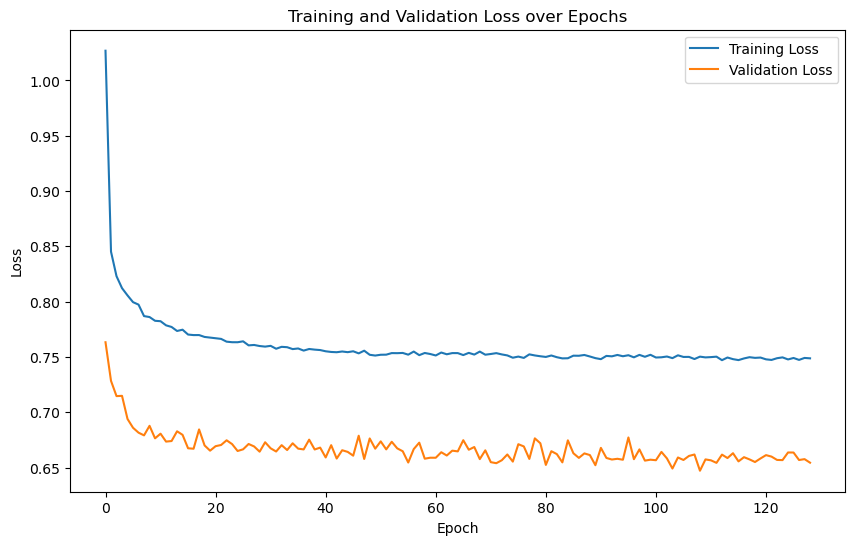

In [18]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('../loss_curve_fig/merfish_human_neocortex_gp_mask_finetune_full_loss_curve.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig('../loss_curve_fig/merfish_human_neocortex_gp_mask_finetune_full_loss_curve.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()


In [19]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.encoder(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.encoder(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [20]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.7837302725968436
Weighted F1 Score: 0.7817631731286065
Macro F1 Score: 0.691944772678817
Random Guess Accuracy: 0.05170816843656664
                          precision    recall  f1-score   support

       Astrocyte-Fibrous       0.69      0.75      0.72       659
      Astrocyte-Immature       0.55      0.58      0.57       738
  Astrocyte-Protoplasmic       0.77      0.66      0.71       478
      Cajal-Retzius cell       0.31      0.24      0.27       123
          EN-IT-Immature       0.63      0.72      0.67      2091
              EN-L2_3-IT       0.80      0.82      0.81      1792
                EN-L4-IT       0.87      0.85      0.86      3031
                EN-L5-ET       0.49      0.35      0.41       189
                EN-L5-IT       0.88      0.87      0.87      1531
              EN-L5_6-NP       0.75      0.60      0.67       284
                EN-L6-CT       0.55      0.51      0.53       588
                EN-L6-IT       0.80      0.76 

In [21]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.encoder(new_data_tensor).detach().cpu().numpy()
new_adata = sc.read_h5ad(data_dir)
new_adata.obsm[f'SSL_GP_FT_{random_seed}'] = SSL_embeddings
new_adata.uns[f'GP_FT_y_test_{random_seed}'] = y_test
new_adata.uns[f'GP_FT_predictions_{random_seed}'] = predictions
new_adata.uns[f'GP_FT_target_names_{random_seed}'] = label_encoder.classes_
new_adata.uns[f'GP_FT_train_loss_{random_seed}'] = train_losses
new_adata.uns[f'GP_FT_val_loss_{random_seed}'] = val_losses
new_adata.write_h5ad(data_dir)

In [22]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "GEX_human_neocortex_GP_mask_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicro_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['GEX_human_neocortex'],
    'method': [re.search(r'human_neocortex_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micro_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micro_f1
1.027	0.763	109	0.647	0.692	0.782	0.784
